# Hidden Markov Model - Implementation and finding score

## Notation
* $T$ - length of the observation sequence
* $N$ - number of (hidden) states
* $M$ - number of observables
* $Q = \{q_0, q_1, ..., q_{N-1}\}$ - hidden states ($|Q| = N$).
* $V = \{0, 1, ..., M-1\}$ - set of possible observations ($|V| = M$).
* $A$ - state transition probabilities
* $B$ - observation probability matrix
* $\pi$ - initial state probability distribution
* $\mathcal{O} = (\mathcal{O}_0, \mathcal{O}_1, ..., \mathcal{O}_{T-1})$ - observation sequence
* $X = (x_0, x_1, ..., x_{T-1})$ where $x_t \in Q$ - hidden state sequence

Having that set defined, we can calculate the probability of any state and observation using the matrices:
* $A = \{a_{i,j}\}$ - being an $N \times N$ transition matrix.
* $B = \{b_{k,j}\}$ - being an $M \times N$ 'emission' matrix.

The probabilities associated with transition and observation (emission) are:
* $a_{i,j} = p(q_j^{(t + 1)} | q_i^{(t)})$,
* $b_j(k) = p(\mathcal{O}_k^{(t)} | q_j^{(t)})$.

The model is therefore defined as a collection: $\lambda = (A, B, \pi)$.

## Fundamental definitions
Since HMM is based on probability vectors and matrices, let's first define objects that will represent the fundamental concepts.
In order to be useful, the objects must reflect on certain properties.
For example, all elements of a probability vector, must be numbers $0 \le x \le 1$ and they must sum up to 1.
Therefore, let's design the objects the way they will inherently safeguard the mathematical properties.

### Probability Vector
We will use the *Probability Vector* to store the infomation of both hidden states and the observables.
Referring to our notation, we will represent probabilities associated with $\mathcal{O}$ and $X$.

In [1]:
%pylab
import numpy as np
import pandas as pd

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
class ProbabilityVector:
    def __init__(self, probabilities: dict):
        states = probabilities.keys()
        probs  = probabilities.values()
        
        assert len(states) == len(probs), "The probabilities must match the states."
        assert len(states) == len(set(states)), "The states must be unique."
        #assert abs(sum(probs) - 1.0) < 1e-12, "Probabilities must sum up to 1."
        assert len(list(filter(lambda x: 0 <= x <= 1, probs))) == len(probs), \
            "Probabilities must be real numbers from [0, 1] interval."
        
        self.states = sorted(probabilities)
        self.values = np.array(list(map(lambda x: probabilities[x], self.states))).reshape(1, -1)
        
    @classmethod
    def initialize(cls, states: list):
        size = len(states)
        rand = np.random.rand(size) / (size**2) + 1 / size
        rand /= rand.sum(axis=0)
        return cls(dict(zip(states, rand)))
    
    @classmethod
    def from_numpy(cls, array: np.ndarray, state: list):
        return cls(dict(zip(states, list(array))))

    @property
    def dict(self):
        return {k:v for k, v in zip(self.states, list(self.values.flatten()))}

    @property
    def df(self):
        return pd.DataFrame(self.values, columns=self.states, index=['probability'])

    def __repr__(self):
        return "P({}) = {}.".format(self.states, self.values)

    def __eq__(self, other):
        if not isinstance(other, ProbabilityVector):
            raise NotImplementedError
        if (self.states == other.states) and (self.values == other.values).all():
            return True
        return False

    def __getitem__(self, state: str) -> float:
        if state not in self.states:
            raise ValueError("Requesting unknown probability state from vector.")
        index = self.states.index(state)
        return float(self.values[0, index])

    def __mul__(self, other) -> np.ndarray:
        if isinstance(other, ProbabilityVector):
            return self.values * other.values
        elif isinstance(other, (int, float)):
            return self.values * other
        else:
            NotImplementedError

    def __rmul__(self, other) -> np.ndarray:
        return self.__mul__(other)

    def __matmul__(self, other) -> np.ndarray:
        if isinstance(other, ProbabilityMatrix):
            return self.values @ other.values

    def __truediv__(self, number) -> np.ndarray:
        if not isinstance(number, (int, float)):
            raise NotImplementedError
        x = self.values
        return x / number if number != 0 else x / (number + 1e-12)

    def argmax(self):
        index = self.values.argmax()
        return self.states[index]

The most natural way to initialize of this object is to use a _dictionary_ as it associates values with unique keys.
Dictionaries, unfortunately, do not provide any assertion mechanisms that put any constraints on the values.
Consequently, we build our custom _ProbabilityVector_ object to ensure that our values behave correctly.
Most importantly, we enforce the following:
* The number of values must equal the number of the keys (names of our states). Although this is not a problem when initializing the object from a dictionary, we will use other ways later.
* All names of the states must be unique (the same arguments apply).
* The probabilities must sum up to 1 (up to the certain tolerance).
* All probabilities must be $0 \le p \le 1$.

Having ensured that, we also provide two alternative ways to instantiate ProbabilityVector objects (decoreated with `@classmethod`).
1. We instantiate the objects randomly - it will be useful when training.
2. We use ready made numpy arrays and use values therein, and only providing the names for the states.

For convenience and debugging, we provide two additional methods for requesitng the values.
Decorated with `@property`, they return the content of the PV object as a dictionary or a pandas dataframe.

The PV objects need to satisfy the following mathematical operations (for the purpose of constructing of HMM):
1. comparison (`__eq__`) - to know if any two PV's are equal,
2. element-wise multiplication of two PV's or multiplication with a scalar (`__mul__` and `__rmul__`).
3. dot product (`__matmul__`) - to perform vector-matrix multiplication
4. division by number (`__truediv__`),
5. `argmax` to find for which state the probability is the highest.
6. `__getitem__` to enable selecting value by the key.

Note that when e.g. multiplying a PV with a scalar, the returned structure is a resulting numpy array, not another PV. This is because multiplying by anything other than 1 would violate the integrity of the PV itself.

Internally, the values are stored as numpy array of size $(1 \times N)$.

$$
p = [p_0, p_1, ..., p_{N-1}]
$$

#### Example

In [3]:
a1 = ProbabilityVector({'rain': 0.7, 'sun': 0.3})
print(a1.df)

a2 = ProbabilityVector({'sun': 0.1, 'rain': 0.9})
print(a2.df)

             rain  sun
probability   0.7  0.3
             rain  sun
probability   0.9  0.1


In [4]:
print(a1)
print("Comparison:", a1 == a2)
print("Element-wise multiplication:", a1 * a2)
print("Argmax:", a1.argmax())
print("Getitem:", a1['rain'])

P(['rain', 'sun']) = [[0.7 0.3]].
Comparison: False
Element-wise multiplication: [[0.63 0.03]]
Argmax: rain
Getitem: 0.7


### Probability Martix
Another object is a *Probability Matrix*, which is a core part of the HMM definition.
Formally, the $A$ and $B$ matrices must be *row-stochastic*, meaning that values of every row must sum up to 1.
We can, therefore, define our PM by stacking several PV's, which we have constructed in a way to guarantee this constraint.

In [5]:
class ProbabilityMatrix:
    def __init__(self, prob_vec_dict: dict):
        
        assert len(prob_vec_dict) > 1, \
            "The numebr of input probability vector must be greater than one."
        assert len(set([str(x.states) for x in prob_vec_dict.values()])) == 1, \
            "All internal states of all the vectors must be indentical."
        assert len(prob_vec_dict.keys()) == len(set(prob_vec_dict.keys())), \
            "All observables must be unique."

        self.states      = sorted(prob_vec_dict)
        self.observables = prob_vec_dict[self.states[0]].states
        self.values      = np.stack([prob_vec_dict[x].values for x in self.states]).squeeze() 

    @classmethod
    def initialize(cls, states: list, observables: list):
        size = len(states)
        rand = np.random.rand(size, len(observables)) / (size**2) + 1 / size
        rand /= rand.sum(axis=1).reshape(-1, 1)
        aggr = [dict(zip(observables, rand[i, :])) for i in range(len(states))]
        pvec = [ProbabilityVector(x) for x in aggr]
        return cls(dict(zip(states, pvec)))

    @classmethod
    def from_numpy(cls, array: np.ndarray, states: list, observables: list):
        p_vecs = [ProbabilityVector(dict(zip(observables, x))) for x in array]
        return cls(dict(zip(states, p_vecs)))

    @property
    def dict(self):
        return self.df.to_dict()

    @property
    def df(self):
        return pd.DataFrame(self.values, columns=self.observables, index=self.states)

    def __repr__(self):
        return "PM {} states: {} -> obs: {}.".format(
            self.values.shape, self.states, self.observables)

    def __getitem__(self, observable: str) -> np.ndarray:
        if observable not in self.observables:
            raise ValueError("Requesting unknown probability observable from the matrix.")
        index = self.observables.index(observable)
        return self.values[:, index].reshape(-1, 1)

Here, the way we instantiate PM's is by supplying a dictionary of PV's to the constructor of the class.
By doing this, we not only ensure that every row of PM is stochastic, but also supply the names for every **observable**.

Our PM can, therefore, give an array of coefficients for any observable.|

Mathematically, the PM is a $(M \times N)$ matrix:

$$
M = 
 \begin{bmatrix}
  c_{1,1} & c_{1,2} & \cdots & c_{1,n} \\
  c_{2,1} & c_{2,2} & \cdots & c_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  c_{m,1} & c_{m,2} & \cdots & c_{m,n} 
 \end{bmatrix}$$
 
 The other methods are implemented in similar way to PV.
 
 #### Example

In [6]:
a1 = ProbabilityVector({'rain': 0.7, 'sun': 0.3})
a2 = ProbabilityVector({'rain': 0.6, 'sun': 0.4})
A  = ProbabilityMatrix({'hot': a1, 'cold': a2})

print(A)
print(A.df)

PM (2, 2) states: ['cold', 'hot'] -> obs: ['rain', 'sun'].
      rain  sun
cold   0.6  0.4
hot    0.7  0.3


In [7]:
b1 = ProbabilityVector({'0S': 0.1, '1M': 0.4, '2L': 0.5})
b2 = ProbabilityVector({'0S': 0.7, '1M': 0.2, '2L': 0.1})

B = ProbabilityMatrix({'0H': b1, '1C': b2})

print(B)
print(B.df)

PM (2, 3) states: ['0H', '1C'] -> obs: ['0S', '1M', '2L'].
     0S   1M   2L
0H  0.1  0.4  0.5
1C  0.7  0.2  0.1


In [8]:
print('Dot product:', a1 @ A)

P = ProbabilityMatrix.initialize(list('abcd'), list('xyz'))
print('Initialization:', P)
print(P.df)

Dot product: [[0.63 0.37]]
Initialization: PM (4, 3) states: ['a', 'b', 'c', 'd'] -> obs: ['x', 'y', 'z'].
          x         y         z
a  0.323803  0.327106  0.349091
b  0.318166  0.326356  0.355478
c  0.311833  0.347983  0.340185
d  0.337223  0.316850  0.345927


## Implementing Hidden Markov Layer
Before we proceed with calculaing of the score, let's use our PV and PM definitions to implment of the Hidden Markov Chain.

Again, we will do so as a class, calling it `HiddenMarkovChain`. It will collate $A$, $B$ and $\pi$.
Later on, we will implement more methods that are applicable to this class.

### Computing score
Computing the score means to find what is the probability of a particular chain of observations $\mathcal{O}$ given our (known) model $\lambda = (A, B, \pi)$. In other words, we are interested in finding $p(\mathcal{O}|\lambda)$.

We can find $p(\mathcal{O}|\lambda)$ by _marginalizing_ all possible chains of the hidden variables $X$, where $X = \{x_0,x_1,...x_{T-1}\}$:

$$
p(\mathcal{O}|\lambda) = \sum_X p(\mathcal{O},X|\lambda) = \sum_X p(\mathcal{O}|X,\lambda)p(X|\lambda)
$$

Since $p(\mathcal{O}|X,\lambda) = \prod_{t=0}^{T-1} b_{x_t}(\mathcal{O}_t)$ (the product of all probabilities related to the observables) and
$p(X|\lambda) = \pi \prod_{t=0}^{T-1} a_{x_{t+1},x_{t}}$ (the product of all probabiities of transitioning from $x_{t}$ to $x_{t+1}$, the probability we are looking for (the **score**) is:

$$
p(\mathcal{O}|\lambda) = \sum_X \pi b_{x_0}(\mathcal{O}_0)a_{x_0,x_1}b_{x_1}(
\mathcal{O}_1)a_{x_1,x_2}...b_{x_{T-1}}(\mathcal{O}_{T-1})a_{T-1,T-2} \\
= \sum_X \pi \prod_{t=0}^{T-1} a_{x_t,x_{t-1}}b_{x_{t}}(\mathcal{O}_t)
$$

This is a naive way of computing of the score, since we need to calculate the probability for every possible chain $X$.
Either way, let's implement it in python:

In [9]:
from itertools import product
from functools import reduce


class HiddenMarkovChain:
    def __init__(self, T, E, pi):
        self.T = T  # transmission matrix A
        self.E = E  # emission matrix B
        self.pi = pi
        self.states = pi.states
        self.observables = E.observables
    
    def __repr__(self):
        return "HML states: {} -> observables: {}.".format(
            len(self.states), len(self.observables))
    
    @classmethod
    def initialize(cls, states: list, observables: list):
        T = ProbabilityMatrix.initialize(states, states)
        E = ProbabilityMatrix.initialize(states, observables)
        pi = ProbabilityVector.initialize(states)
        return cls(T, E, pi)
    
    def _create_all_chains(self, chain_length):
        return list(product(*(self.states,) * chain_length))
    
    def score(self, observations: list) -> float:
        def mul(x, y): return x * y
        
        score = 0
        all_chains = self._create_all_chains(len(observations))
        for idx, chain in enumerate(all_chains):
            expanded_chain = list(zip(chain, [self.T.states[0]] + list(chain)))
            expanded_obser = list(zip(observations, chain))
            
            p_observations = list(map(lambda x: self.E.df.loc[x[1], x[0]], expanded_obser))
            p_hidden_state = list(map(lambda x: self.T.df.loc[x[1], x[0]], expanded_chain))
            p_hidden_state[0] = self.pi[chain[0]]
            
            score += reduce(mul, p_observations) * reduce(mul, p_hidden_state)
        return score

In [10]:
a1 = ProbabilityVector({'1H': 0.7, '2C': 0.3})                                                                
a2 = ProbabilityVector({'1H': 0.4, '2C': 0.6})                                                                
                                                                                                               
b1 = ProbabilityVector({'1S': 0.1, '2M': 0.4, '3L': 0.5})                                                     
b2 = ProbabilityVector({'1S': 0.7, '2M': 0.2, '3L': 0.1})                                                     
                                                                                                                
A = ProbabilityMatrix({'1H': a1, '2C': a2})                                                                   
B = ProbabilityMatrix({'1H': b1, '2C': b2})                                                                   
pi = ProbabilityVector({'1H': 0.6, '2C': 0.4})

hmc = HiddenMarkovChain(A, B, pi)
observations = ['1S', '2M', '3L', '2M', '1S']

print("Score for {} is {:f}.".format(observations, hmc.score(observations)))

Score for ['1S', '2M', '3L', '2M', '1S'] is 0.003482.


If our implementation is correct, then all score values for all possible observation chains, for a given model $\lambda$ should add up to one.
Namely:

$$
\sum_{\mathcal{O}} p(\mathcal{O}|\lambda) = 1
$$

In [11]:
all_possible_observations = {'1S', '2M', '3L'}
chain_length = 3  # any int > 0
all_observation_chains = list(product(*(all_possible_observations,) * chain_length))
all_possible_scores = list(map(lambda obs: hmc.score(obs), all_observation_chains))
print("All possible scores added: {}.".format(sum(all_possible_scores)))

All possible scores added: 1.0.


Indeed.

## Score with Forward-pass
Computing the score the way we did above is kind of naive.
In order to find the number for a partivular observation chain $\mathcal{O}$, we have to compute the score for all possble latent variable sequences $X$.
That requries $2TN^T$ multiplications, which even for small numbers takes time.

Another way to do it is to calculate _partial observations of a sequence up to time $t$_.
For $i \in \{0, 1, ..., N-1\}$ and $t \in \{0, 1, ..., T-1\}$:
$$
\alpha_t(i) = p(\mathcal{O}_0, \mathcal{O}_1, ..., \mathcal{O}_t, x_t = q_i|\lambda)
$$

Consequently,
$$
\alpha_0(i) = \pi b_i(\mathcal{O}_0) \quad \text{for} \quad i = 0, 1, ..., N-1
$$
and
$$
\alpha_t(i) = \left[\sum_{j=0}^{N-1} \alpha_{t-1}(j) a_{j,i}\right] b_i(\mathcal{O_t})
$$

Then
$$
p(\mathcal{O}|\lambda) = \sum_{i=0}^{N-1} \alpha_{T-1}(i)
$$

Note that $\alpha_t$ is a vector of lenght $N$. The sum of the product $\alpha_{t-1}(j)a_{j,i}$ can, in fact, be written as a dot product. Therefore:
$$
\left[\sum_{j=0}^{N-1} \alpha_{t-1}(j)a_{j,i}\right] b_i(\mathcal{O}_t) = [\vec{\alpha}_{t-1} \cdot \mathbf{A}] \star \vec{b}^T(\mathcal{O}_t) \to \vec{\alpha}_t
$$
where by $\star$ we denote an element-wise multiplication.

With this implementation, we reduce the number of multiplication to $N^2T$ and can take advantage of vectorization.

In [12]:
class HiddenMarkovChain_FP(HiddenMarkovChain):
    def _alphas(self, observations: list) -> np.ndarray:
        alphas = np.zeros((len(observations), len(self.states)))
        alphas[0, :] = self.pi.values * self.E[observations[0]].T
        for t in range(1, len(observations)):
            alphas[t, :] = (alphas[t - 1, :].reshape(1, -1) 
                         @ self.T.values) * self.E[observations[t]].T
        return alphas
    
    def score(self, observations: list) -> float:
        alphas = self._alphas(observations)
        return float(alphas[-1].sum())

In [13]:
hmc_fp = HiddenMarkovChain_FP(A, B, pi)

observations = ['1S', '2M', '3L', '2M', '1S']
print("Score for {} is {:f}.".format(observations, hmc_fp.score(observations)))

Score for ['1S', '2M', '3L', '2M', '1S'] is 0.003482.


Let's also validate:

In [14]:
all_possible_observations = {'1S', '2M', '3L'}
chain_length = 3  # any int > 0
all_observation_chains = list(product(*(all_possible_observations,) * chain_length))
all_possible_scores = list(map(lambda obs: hmc_fp.score(obs), all_observation_chains))
print("All possible scores added: {}.".format(sum(all_possible_scores)))

All possible scores added: 1.0.


...yup.

## Simulation and convergence
Let's test one more thing.
Basically, let's take our $\lambda = (A, B, \pi)$ and use it to generate a sequence of random observables, starting from some initial state probability $\pi$.

If the desired length $T$ is "large enough", we would expect that the system to converge on a sequence that, on average, gives the same number of events as we would expect from $\mathbf{A}$ and $\mathbf{B}$ matrices directly.
In other words, the transition and the emission matrices "decide", with certain probability, what the next state will be and what observation we will get, for every step, respectively.
Therefore, what may initially look like random events, on average shoud reflect the coefficients of the matrices themselves.
Let's check that as well.

In [15]:
class HiddenMarkovChain_Simulation(HiddenMarkovChain):
    def run(self, length: int) -> (list, list):
        assert length >= 0, "The chain needs to be a non-negative number."
        s_history = [0] * (length + 1)
        o_history = [0] * (length + 1)
        
        prb = self.pi.values
        obs = prb @ self.E.values
        s_history[0] = np.random.choice(self.states, p=prb.flatten())
        o_history[0] = np.random.choice(self.observables, p=obs.flatten())
        
        for t in range(1, length + 1):
            prb = prb @ self.T.values
            obs = prb @ self.E.values
            s_history[t] = np.random.choice(self.states, p=prb.flatten())
            o_history[t] = np.random.choice(self.observables, p=obs.flatten())
        
        return o_history, s_history

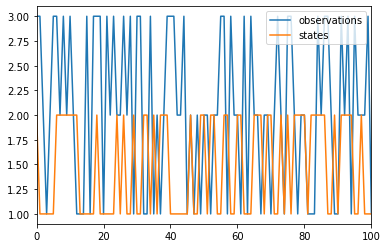

In [16]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)
observation_hist, states_hist = hmc_s.run(100)  # length = 1000
stats = pd.DataFrame({
    'observations': observation_hist,
    'states': states_hist}).applymap(lambda x: int(x[0])).plot()

### States
The state matrix $\mathbf{A}$ is given by the following coefficients:
* $p(q_{t+1}=\text{'1H'})|q_t=\text{'1H'}) = 0.7$
* $p(q_{t+1}=\text{'1H'})|q_t=\text{'2C'}) = 0.4$
* $p(q_{t+1}=\text{'2C'})|q_t=\text{'1H'}) = 0.3$
* $p(q_{t+1}=\text{'2C'})|q_t=\text{'2C'}) = 0.6$

Consequently, the probability of "being" in the state '1H' at $t + 1$, regardless of the previous state, is equal to:

$$
p(q_{t+1}=\text{'1H'}) = p(q_{t+1}=\text{'1H'}|q_t=\text{'1H'})p(q_t=\text{'1H'})
                       + p(q_{t+1}=\text{'1H'}|q_t=\text{'2C'})p(q_t=\text{'2C'})
$$
If we assume that the _prior_ probabilities of being at some state at $t$ are totally random, then $p(q_{t+1}=\text{'1H'}) = 1$ and $p(q_{t+1}=\text{'2C'}) = 0.9$, which after renormalizing give 0.55 and 0.45, respectively.

If we cound the number of occurences of each state and divide it by the number of elements in our sequence, we would get closer and closer to these number as the lenght of the sequence grows.

For example:

In [17]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)

stats = {}
for length in np.logspace(1, 5, 40).astype(int):
    observation_hist, states_hist = hmc_s.run(length)
    stats[length] = pd.DataFrame({
        'observations': observation_hist,
        'states': states_hist}).applymap(lambda x: int(x[0]))

In [18]:
S = np.array(list(map(lambda x: 
        x['states'].value_counts().to_numpy() / len(x), stats.values())))

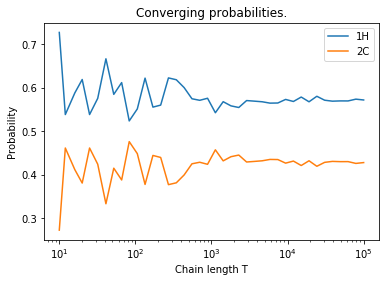

In [20]:
plt.semilogx(np.logspace(1, 5, 40).astype(int), S)
plt.xlabel('Chain length T')
plt.ylabel('Probability')
plt.title('Converging probabilities.')
plt.legend(['1H', '2C'])
plt.show()

## Conclusion
This notebook was all about defining of the fundamental building blocks to our model.
In the next notebook, we will show implement the methods to uncover the latent variables, given the observation chain.